# Step 1: Importing the Libraries

In [1]:
# Import pandas for data manipulation and analysis
import os
import pandas as pd

# Import numpy for numerical operations
import numpy as np

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import seaborn for advanced statistical visualization
import seaborn as sns

# Import regex module for text cleaning
import re

# Import combinations for skill pair generation
from itertools import combinations

# Import Counter to count skill pairs
from collections import Counter

# Set seaborn style for better visuals
sns.set_style("whitegrid")

# Set default figure size for all plots
plt.rcParams["figure.figsize"] = (10,6)


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Step 2: Inspecting the data

In [2]:
# Read Excel file
df = pd.read_csv('data/indian-job-market-dataset-2025.csv')

# Show first five rows
print(df.head())

                                         title         jobId currency  \
0                    Sr. HR Recruiter (NON IT)  270925008041      INR   
1                      Fire And Safety Officer  270925007584      INR   
2  Opening For Performance Marketing - Chennai  270925007492      INR   
3                    Medical Billing Executive  270925007443      INR   
4  Senior Group Product Manager -  CNS Therapy  270925007430      INR   

  jobUploaded                                        companyName  \
0  6 Days Ago                                              Orion   
1  6 Days Ago  Apollo Hospitals International Limited, Ahmedabad   
2  6 Days Ago                            TVS Credit Services Ltd   
3  6 Days Ago                                GNR Global Services   
4  6 Days Ago                             Cadila Pharmaceuticals   

                                       tagsAndSkills experience  \
0  Communication,Manpower,Staffing,Convincing Pow...    2-4 Yrs   
1  Safety Officer 

In [3]:
df.shape


(97929, 17)

# Step 3: Data Cleaning

In [4]:
# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()

In [5]:
# Drop rows where job title OR skills are missing (null)
df = df.dropna(subset=["title", "tagsAndSkills"])

In [6]:
# Use .loc to safely modify the column in the original DataFrame
df.loc[:, "title"] = df["title"].str.lower()

In [7]:
# Convert skills text to lowercase for uniformity
df.loc[:,"tagsAndSkills"] = df["tagsAndSkills"].str.lower()


In [8]:
# Convert location to lowercase
df.loc[:,"location"] = df["location"].str.lower()


In [9]:
# Check dataset shape after cleaning
df.shape

(97358, 17)

# Step 4: Feature Engineering(Experience and Salary)

In [10]:
# Calculate average experience using min and max columns
df.loc[:,"avg_experience"] = (df["minimumExperience"] + df["maximumExperience"]) / 2


In [11]:
# Calculate average salary using min and max columns
df.loc[:,"avg_salary"] = (df["minimumSalary"] + df["maximumSalary"]) / 2

# Convert salary column to numeric
#error='coerce' means if any value cannot be converted to a number,replace it with Nan(Missing value) insted of giving error
df.loc[:,"avg_salary"] = pd.to_numeric(df["avg_salary"], errors="coerce")

# Convert experience column to numeric
df.loc[:,"avg_experience"] = pd.to_numeric(df["avg_experience"], errors="coerce")



In [12]:
# View summary statistics
df[["avg_experience", "avg_salary"]].describe()

,avg_experience,avg_salary
count,97358.000000,9.735800e+04
mean,5.845195,2.584594e+05
std,3.978192,6.985912e+05
min,0.000000,0.000000e+00
25%,3.000000,0.000000e+00
50%,5.000000,0.000000e+00
75%,7.500000,3.000000e+05
max,32.500000,8.250000e+07


# Step 5: Intelligent Role Classification

In [13]:
df["title"].value_counts().head()

title
application developer             2039
application lead                  1347
sales executive                    583
software development engineer      497
business development executive     457
Name: count, dtype: int64

# Step6: Clean Title

In [14]:
# Make a copy to preserve original title
df["clean_title"] = df["title"]

# Convert to lowercase
df["clean_title"] = df["clean_title"].str.lower()

# Remove text inside brackets (experience, wfh, etc.)
df["clean_title"] = df["clean_title"].str.replace(r"\(.*?\)", "", regex=True)

# Remove content after hyphen (usually location or extra info)
df["clean_title"] = df["clean_title"].str.split("-").str[0]

# Remove newline characters
df["clean_title"] = df["clean_title"].str.replace("\n", " ", regex=False)

# Remove multiple spaces
df["clean_title"] = df["clean_title"].str.replace(r"\s+", " ", regex=True)

# Remove non-alphabet characters
df["clean_title"] = df["clean_title"].str.replace(r"[^a-zA-Z ]", "", regex=True)

# Strip leading/trailing spaces
df["clean_title"] = df["clean_title"].str.strip()

# Check result
df[["title", "clean_title"]].head(5)

,title,clean_title
0,sr. hr recruiter (non it),sr hr recruiter
1,fire and safety officer,fire and safety officer
2,opening for performance marketing - chennai,opening for performance marketing
3,medical billing executive,medical billing executive
4,senior group product manager - cns therapy,senior group product manager


# Step7: Extract Core Designation

In [15]:
def normalize_designation(title):
    # Handle NaN or non-string values
    if pd.isna(title) or not isinstance(title, str):
        return "unknown"  # or return title, or "missing", whatever fits your needs
    
    # Data roles
    if "data scientist" in title:
        return "data scientist"
    elif "data analyst" in title:
        return "data analyst"
    
    # Software roles
    elif "software development engineer" in title:
        return "software development engineer"
    elif "application developer" in title:
        return "application developer"
    elif "developer" in title:
        return "developer"
    
    # Sales roles
    elif "sales executive" in title:
        return "sales executive"
    elif "business development executive" in title:
        return "business development executive"
    
    # Healthcare
    elif "pharmacist" in title:
        return "pharmacist"
    elif "doctor" in title:
        return "doctor"
    
    # Management
    elif "manager" in title:
        return "manager"
    elif "lead" in title:
        return "lead"
    
    else:
        return title  # fallback

In [16]:
# Fill NaN values with a placeholder
df["clean_title"] = df["clean_title"].fillna("unknown")

# Then apply your function
df["normalized_title"] = df["clean_title"].apply(normalize_designation)

In [17]:
# Remove rows with NaN in clean_title
df = df.dropna(subset=["clean_title"])

# Then apply your function
df["normalized_title"] = df["clean_title"].apply(normalize_designation)

In [18]:
# Check how many NaN values you have
print(f"Number of NaN values: {df['clean_title'].isna().sum()}")
print(f"Percentage of NaN values: {(df['clean_title'].isna().sum() / len(df)) * 100:.2f}%")

# Check the data types
print(f"Data type: {df['clean_title'].dtype}")

Number of NaN values: 0
Percentage of NaN values: 0.00%
Data type: object


In [19]:
# Apply normalization
df["normalized_title"] = df["clean_title"].apply(normalize_designation)

df["normalized_title"].value_counts().head(10)

normalized_title
manager                           15210
developer                          6870
lead                               5560
application developer              2306
sales executive                    2157
business development executive      704
software development engineer       602
data engineer                       435
executive                           390
senior software engineer            387
Name: count, dtype: int64

In [20]:
def classify_role(title):
    
    if any(x in title for x in ["data scientist", "data analyst"]):
        return "Data Science"
    
    elif any(x in title for x in ["developer", "engineer", "application"]):
        return "Software Engineering"
    
    elif any(x in title for x in ["sales", "business development"]):
        return "Sales"
    
    elif any(x in title for x in ["pharmacist", "doctor", "nurse", "medical"]):
        return "Healthcare"
    
    elif any(x in title for x in ["account", "finance", "billing", "tax"]):
        return "Finance"

    # Marketing related roles
    elif any(x in title for x in ["marketing", "seo", "growth"]):
        return "Marketing"
    
    elif any(x in title for x in ["hr", "recruit"]):
        return "Human Resources"
    
    elif any(x in title for x in ["manager", "lead", "head"]):
        return "Management"
    
    else:
        return "Other"

# Apply role classification
df["role_group"] = df["normalized_title"].apply(classify_role)

df["role_group"].value_counts()

role_group
Other                   41987
Software Engineering    21620
Management              21579
Sales                    5763
Finance                  2362
Human Resources          1629
Marketing                1004
Healthcare                859
Data Science              555
Name: count, dtype: int64

In [21]:
def Data_analyst_roles(title):
    # Data roles
    if "data scientist" in title:
        return "data scientist"
    elif "data analyst" in title:
        return "data analyst"
    
    

df["Data analyst"] = df["clean_title"].apply(Data_analyst_roles)
df["Data analyst"].value_counts().head()

Data analyst
data scientist    299
data analyst      256
Name: count, dtype: int64

In [22]:
print("Unique titles before cleaning:", df["title"].nunique())
print("Unique titles after normalization:", df["normalized_title"].nunique())

Unique titles before cleaning: 53767
Unique titles after normalization: 27268


# Step 9: Role Distribution Visualization

In [23]:
# Check all column names in your DataFrame
print("All columns in DataFrame:")
print(df.columns.tolist())

# Also check if there's a similar column name (typo, different case, etc.)
print("\nColumns containing 'role' or 'group':")
role_columns = [col for col in df.columns if 'role' in col.lower() or 'group' in col.lower()]
print(role_columns)

All columns in DataFrame:
['title', 'jobId', 'currency', 'jobUploaded', 'companyName', 'tagsAndSkills', 'experience', 'salary', 'location', 'companyId', 'ReviewsCount', 'AggregateRating', 'jobDescription', 'minimumSalary', 'maximumSalary', 'minimumExperience', 'maximumExperience', 'avg_experience', 'avg_salary', 'clean_title', 'normalized_title', 'role_group', 'Data analyst']

Columns containing 'role' or 'group':
['role_group']


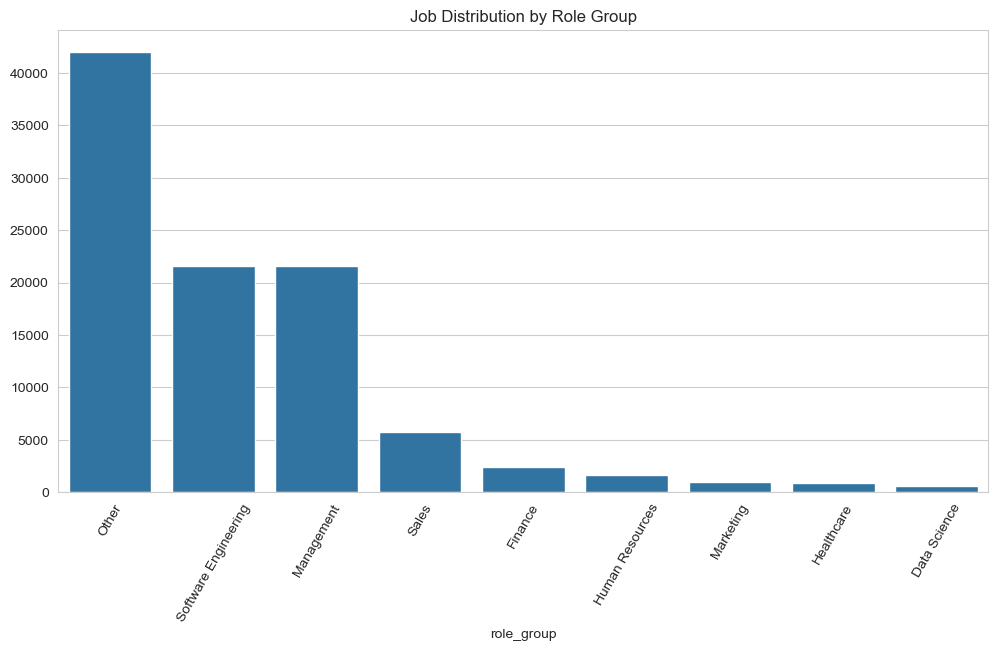

In [24]:
# Count number of jobs per role group
role_counts = df["role_group"].value_counts()

plt.figure(figsize=(12,6)) 

# Create barplot showing distribution
sns.barplot(x=role_counts.index, y=role_counts.values)

# Rotate x labels for better readability
plt.xticks(rotation=60)

# Add title
plt.title("Job Distribution by Role Group")

# Show plot
plt.show()

# Step 10: Salary Distribution by Role

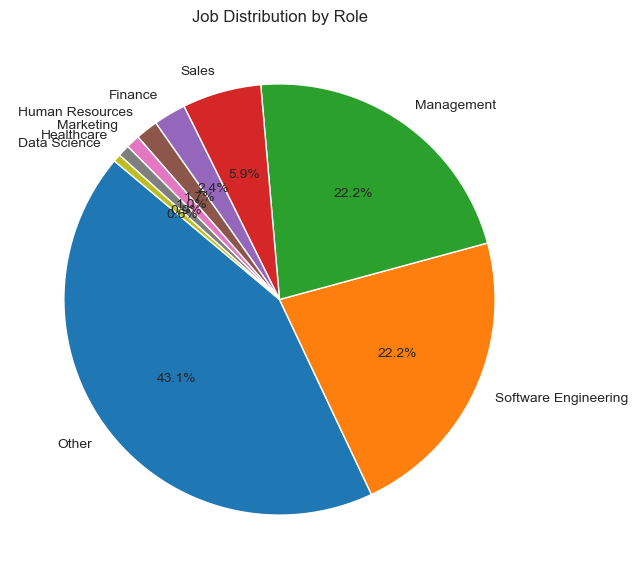

In [25]:
role_counts = df["role_group"].value_counts()

plt.figure(figsize=(7,7))

plt.pie(
    role_counts,
    labels=role_counts.index,
    autopct="%1.1f%%",
    startangle=140
)

plt.title("Job Distribution by Role")
plt.show()


# Step 10: Experience vs Salary Relationship

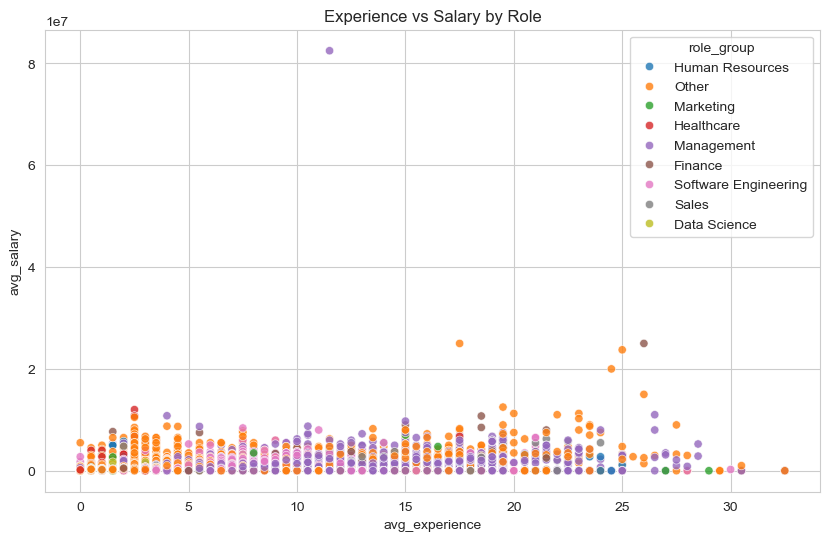

In [26]:
# Scatterplot to observe correlation between experience and salary
sns.scatterplot(
    data=df,
    x="avg_experience",
    y="avg_salary",
    hue="role_group",  # Color by role
    alpha=0.8          # Slight transparency
)

# Add title
plt.title("Experience vs Salary by Role")

# Show plot
plt.show()

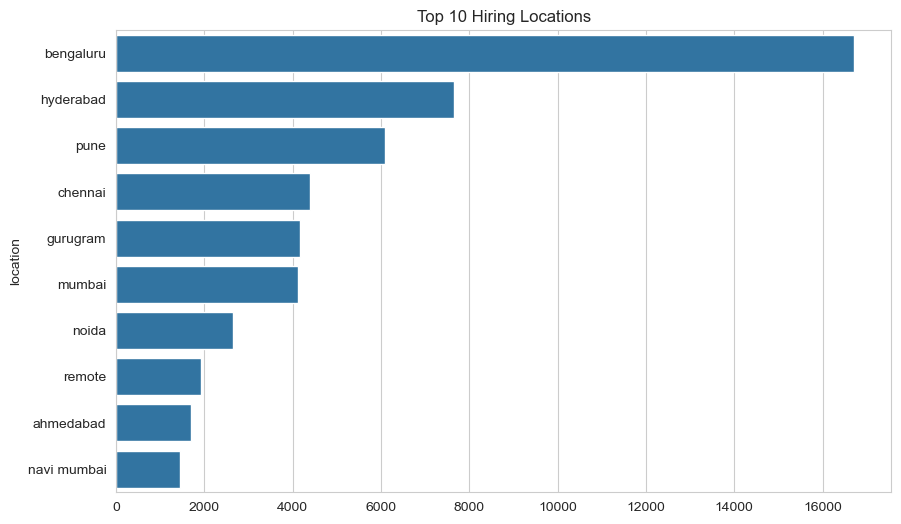

In [27]:
# Identify top 10 locations by job count
top_cities = df["location"].value_counts().head(10)

# Plot horizontal bar chart
sns.barplot(x=top_cities.values, y=top_cities.index)

# Add title
plt.title("Top 10 Hiring Locations")

# Show plot
plt.show()


In [28]:
# Remove rows where rating is missing
df = df.dropna(subset=["AggregateRating"])

# Use .loc to explicitly modify the original DataFrame
df.loc[:, "AggregateRating"] = pd.to_numeric(df["AggregateRating"], errors="coerce")

# Create rating bands using .loc
df.loc[:, "rating_band"] = pd.cut(
    df["AggregateRating"],
    bins=[0, 2, 3, 4, 5],
    labels=["Low (0-2)", "Below Avg (2-3)", "Good (3-4)", "Excellent (4-5)"],
    include_lowest=True
)

# Check if created
df[["AggregateRating", "rating_band"]].head()

,AggregateRating,rating_band
1,4.0,Good (3-4)
2,4.2,Excellent (4-5)
4,3.4,Good (3-4)
6,3.7,Good (3-4)
7,4.1,Excellent (4-5)


C:\Users\Sachin Bodke\AppData\Local\Temp\ipykernel_3356\2431792615.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("rating_band")["avg_salary"]


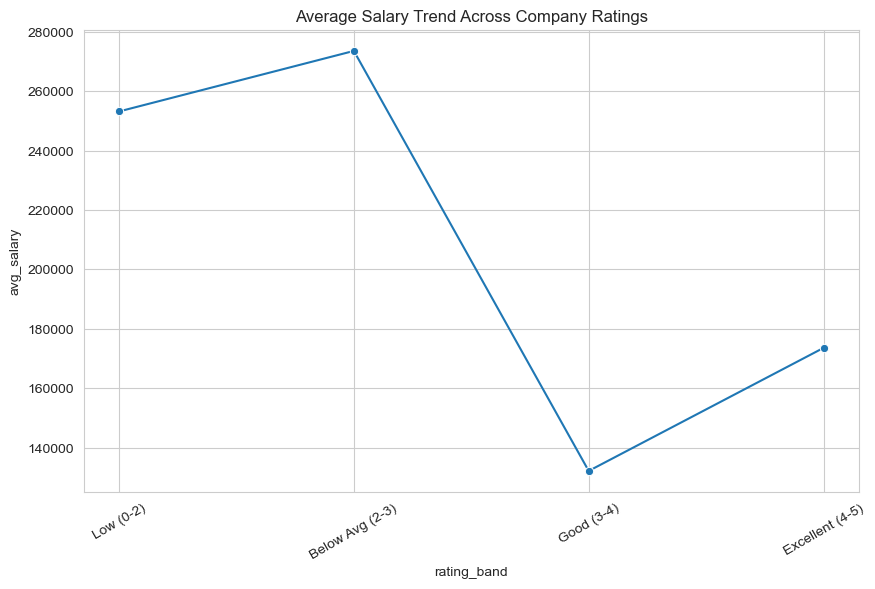

In [29]:
# Calculate average salary per rating band
rating_salary = (
    df.groupby("rating_band")["avg_salary"]
    .mean()
    .reset_index()
)

# Line plot
sns.lineplot(
    data=rating_salary,
    x="rating_band",
    y="avg_salary",
    marker="o"
)

plt.title("Average Salary Trend Across Company Ratings")
plt.xticks(rotation=30)
plt.show()